
# Experiment Analysis (setup results)

Two blocks:
1) **Hessian eigenvalue tubes**: mean ± std across steps for sorted eigenvalues, **with index-range selection**.
2) **Many-runs PCA**: fit PCA on the sample-mean trajectory; plot PC pairs for all samples.


In [3]:

import os, json
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#!/usr/bin/env python3
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
#!/usr/bin/env python3
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os, math
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


## Hessians stats

In [2]:

# --- CONFIG ---
SETUP_NUM = 1
BASE_DIR = Path('./')
RESULTS_DIR = BASE_DIR / f'setup{SETUP_NUM}'

# Hessian LRs to analyze
LRS_HESS = [0.1, 0.01]

print("Using RESULTS_DIR =", RESULTS_DIR)


Using RESULTS_DIR = setup1


## Отдельный параметр отслеживаем 


In [119]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os, math
import numpy as np
import torch
import matplotlib.pyplot as plt

# ============== настройки ==============
BASE_DIR = "./setup1"
LR_TO_USE = "0.01"  # "0.01" или "0.1"
PATH = os.path.join(BASE_DIR, f"weights_lr{LR_TO_USE}.pt")  # ожидаем shape [N, T, D]

W = torch.load(PATH, map_location="cpu")
W = W.detach().float()
N, T, D = W.shape
W.shape

torch.Size([1000, 1111, 386])

In [164]:
num_p = 383
p_trajectories = W[:,:,num_p].numpy()

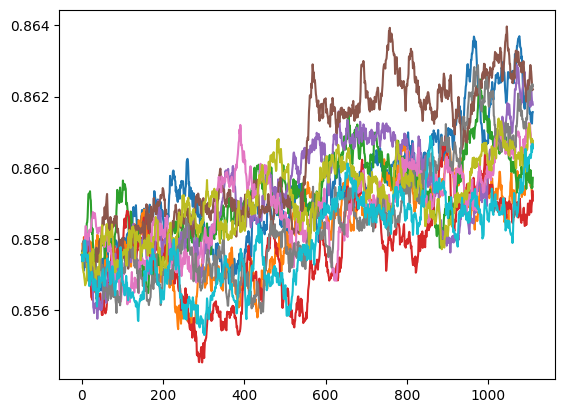

In [165]:
for num_sample in range(10):
    plt.plot(p_trajectories[num_sample,:])

mu_hat = 4.226108e-06 sigma_hat = 0.00019741963


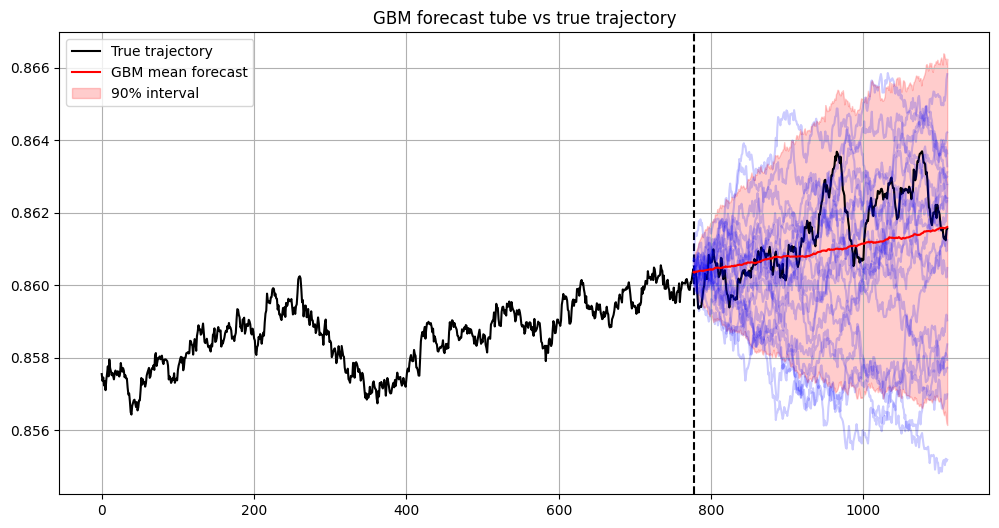

In [166]:

num_sample = 0   # возьмем первую траекторию для примера
S = p_trajectories[num_sample, :]

# Train/Test сплит
train_ratio = 0.7
split = int(len(S) * train_ratio)
S_train, S_test = S[:split], S[split:]
dt = 1.0  # если дискретизация равномерная

# Лог-доходности
r = np.diff(np.log(S_train))

# Оценка параметров GBM
mu_hat = np.mean(r)/dt + 0.5*np.var(r)/dt
sigma_hat = np.sqrt(np.var(r)/dt)

print("mu_hat =", mu_hat, "sigma_hat =", sigma_hat)

# --- Прогнозирование "трубкой" ---
n_steps = len(S_test)
n_paths = 300  # число сэмплированных траекторий

paths = np.zeros((n_paths, n_steps))
for j in range(n_paths):
    S_pred = [S_train[-1]]
    for i in range(n_steps):
        dW = np.random.randn() * np.sqrt(dt)
        next_S = S_pred[-1] * np.exp((mu_hat - 0.5*sigma_hat**2)*dt + sigma_hat*dW)
        S_pred.append(next_S)
    paths[j,:] = S_pred[1:]

# Среднее и доверительные интервалы
mean_path = paths.mean(axis=0)
low_path  = np.percentile(paths, 5, axis=0)
high_path = np.percentile(paths, 95, axis=0)

# --- Визуализация ---
plt.figure(figsize=(12,6))

# Истинная траектория
plt.plot(range(len(S)), S, label="True trajectory", color="black")

# Train/Test split
plt.axvline(split, color="k", linestyle="--")

# Несколько сэмплов из трубки
for j in range(20):
    plt.plot(range(split, len(S)), paths[j,:], color="blue", alpha=0.2)

# Средняя и доверительные интервалы
plt.plot(range(split, len(S)), mean_path, color="red", label="GBM mean forecast")
plt.fill_between(range(split, len(S)), low_path, high_path, color="red", alpha=0.2, label="90% interval")

plt.legend()
plt.grid(True)
plt.title("GBM forecast tube vs true trajectory")
plt.show()


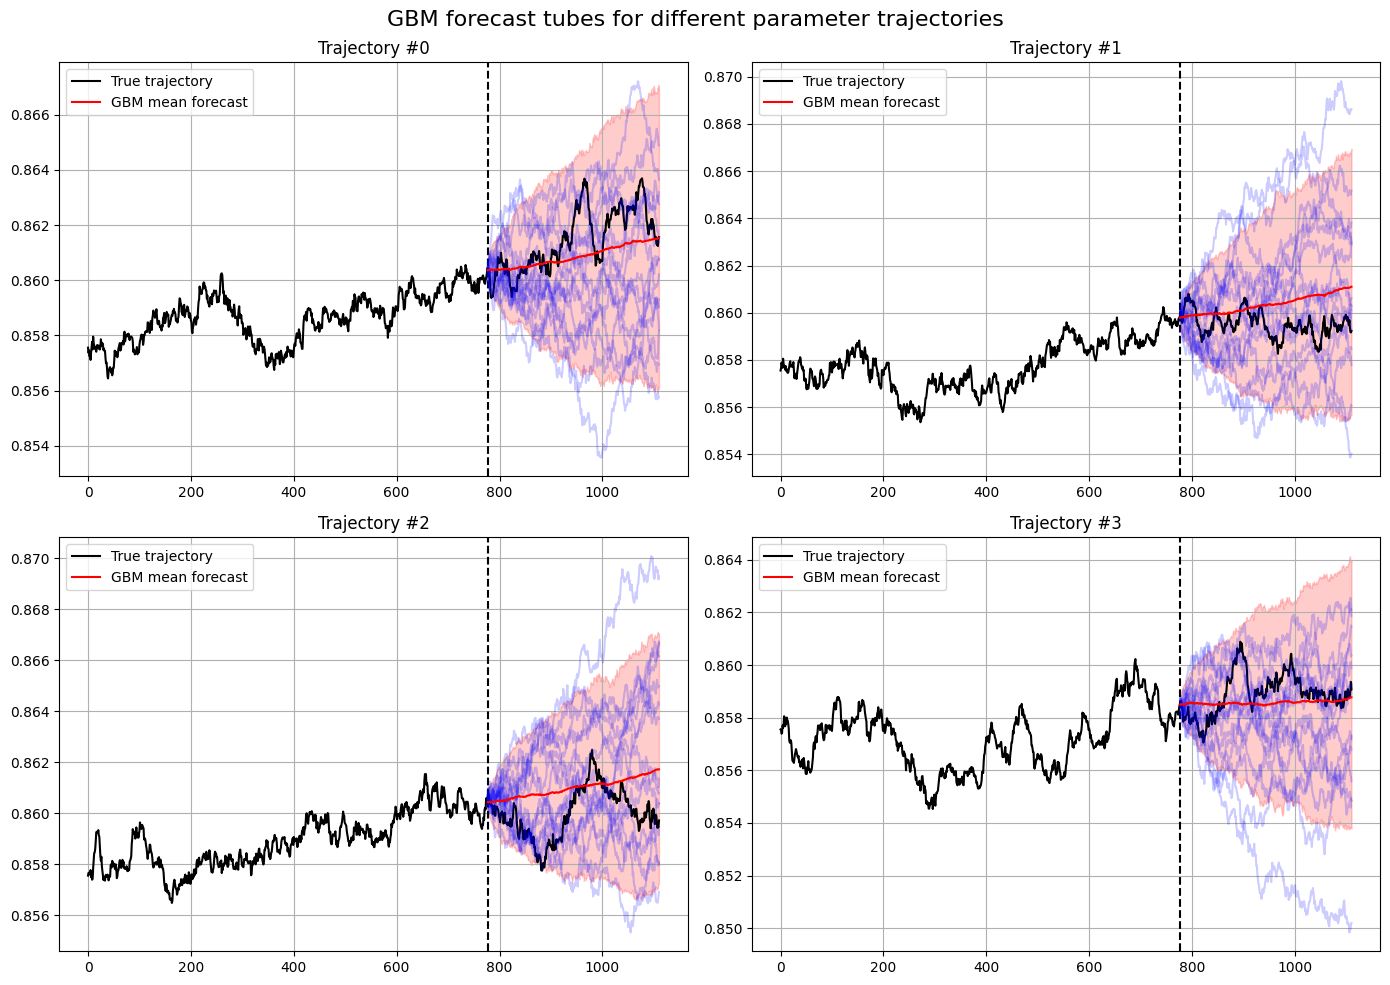

In [167]:
def fit_and_forecast(S, train_ratio=0.7, dt=1.0, n_paths=300):
    split = int(len(S) * train_ratio)
    S_train, S_test = S[:split], S[split:]

    # Лог-доходности
    r = np.diff(np.log(S_train))

    # Оценка параметров GBM
    mu_hat = np.mean(r)/dt + 0.5*np.var(r)/dt
    sigma_hat = np.sqrt(np.var(r)/dt)

    # Прогнозирование "трубкой"
    n_steps = len(S_test)
    paths = np.zeros((n_paths, n_steps))
    for j in range(n_paths):
        S_pred = [S_train[-1]]
        for i in range(n_steps):
            dW = np.random.randn() * np.sqrt(dt)
            next_S = S_pred[-1] * np.exp((mu_hat - 0.5*sigma_hat**2)*dt + sigma_hat*dW)
            S_pred.append(next_S)
        paths[j, :] = S_pred[1:]

    return split, paths, S

# --- Визуализация нескольких ---
n_show = 4  # число траекторий для отображения
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for idx, ax in enumerate(axs.flatten()[:n_show]):
    S = p_trajectories[idx, :]
    split, paths, S_true = fit_and_forecast(S)

    mean_path = paths.mean(axis=0)
    low_path  = np.percentile(paths, 5, axis=0)
    high_path = np.percentile(paths, 95, axis=0)

    # Истинная траектория
    ax.plot(range(len(S_true)), S_true, color="black", label="True trajectory")
    ax.axvline(split, color="k", linestyle="--")

    # Несколько сэмплов из трубки
    for j in range(15):
        ax.plot(range(split, len(S_true)), paths[j,:], color="blue", alpha=0.2)

    # Средний прогноз и доверительный интервал
    ax.plot(range(split, len(S_true)), mean_path, color="red", label="GBM mean forecast")
    ax.fill_between(range(split, len(S_true)), low_path, high_path, color="red", alpha=0.2)

    ax.set_title(f"Trajectory #{idx}")
    ax.grid(True)
    ax.legend()

plt.suptitle("GBM forecast tubes for different parameter trajectories", fontsize=16)
plt.tight_layout()
plt.show()


In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

def fit_trend_candidates(trajectories):
    num_samples, T = trajectories.shape
    t = np.arange(1, T+1)
    mean_real = trajectories.mean(axis=0)
    S0 = trajectories[0,0]

    candidates = {
        "-log(t)": (lambda t, beta: S0 - beta * np.log(t+1), [1.0]),
        "-log log(t)": (lambda t, beta: S0 - beta * np.log(np.log(t+2)), [1.0]),
        "power law": (lambda t, beta, gamma: S0 - beta * (t**gamma), [1.0, 0.5]),
        "rational": (lambda t, beta, c: S0 - beta/(t+c), [1.0, 1.0]),
        "exp power": (lambda t, beta, gamma: S0 * np.exp(-beta * (t**gamma)), [0.01, 0.5]),
        "log+power": (lambda t, beta1, gamma, beta2: S0 - beta1*(t**gamma) - beta2*np.log(t+1), [1.0, 0.5, 0.5]),
        "shifted log": (lambda t, beta, c: S0 - beta * np.log(t+c), [1.0, 2.0]),
        "logistic": (lambda t, beta, gamma: S0 / (1 + beta*(t**gamma)), [0.01, 0.5])
    }

    results = {}
    for name, (func, p0) in candidates.items():
        try:
            popt, _ = curve_fit(func, t, mean_real, p0=p0, maxfev=20000)
            y_fit = func(t, *popt)
            mse = mean_squared_error(mean_real, y_fit)
            results[name] = {"params": popt, "fit": y_fit, "mse": mse}
        except Exception as e:
            print(f"⚠️ Не получилось подогнать {name}: {e}")

    return t, mean_real, results

def fit_trend_candidates_fixed(trajectories):
    num_samples, T = trajectories.shape
    t = np.arange(1, T+1)
    mean_real = trajectories.mean(axis=0)
    S0 = trajectories[0,0]

    candidates = {
        "-log(t)": (lambda t, beta: S0 - beta * np.log(t+1), [1.0]),
        "power law": (lambda t, beta, gamma: S0 - beta * (t**gamma), [1.0, 0.5]),
        "rational": (lambda t, beta, c: S0 - beta/ (t+c) + beta/c, [1.0, 1.0]),
        "logistic": (lambda t, beta, gamma: S0 / (1 + beta*(t**gamma)), [0.01, 0.5])
    }

    results = {}
    for name, (func, p0) in candidates.items():
        try:
            popt, _ = curve_fit(func, t, mean_real, p0=p0, maxfev=20000)
            y_fit = func(t, *popt)
            mse = mean_squared_error(mean_real, y_fit)
            results[name] = {"params": popt, "fit": y_fit, "mse": mse}
        except Exception as e:
            print(f"⚠️ Не получилось подогнать {name}: {e}")

    return t, mean_real, results


def plot_trend_candidates(t, mean_real, results):
    plt.figure(figsize=(12,6))
    plt.plot(t, mean_real, label="Real mean", color="black", linewidth=2)
    for name, res in results.items():
        plt.plot(t, res["fit"], label=f"{name} (MSE={res['mse']:.4f})")
    plt.title("Trend fitting candidates")
    plt.xlabel("Time step")
    plt.ylabel("Mean trajectory")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_top_trends(t, mean_real, results, top_k=3):
    sorted_results = sorted(results.items(), key=lambda x: x[1]["mse"])
    top_results = sorted_results[:top_k]

    plt.figure(figsize=(12,6))
    # plt.plot(t, mean_real, label="Real mean", color="black", linewidth=2)
    for name, res in top_results:
        plt.plot(t, res["fit"], label=f"{name} (MSE={res['mse']:.4f})")

    plt.title(f"Top {top_k} trend fits")
    plt.xlabel("Time step")
    plt.ylabel("Mean trajectory")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"🏆 Top {top_k} по MSE:")
    for name, res in top_results:
        print(f"{name}: MSE={res['mse']:.4f}, params={res['params']}")

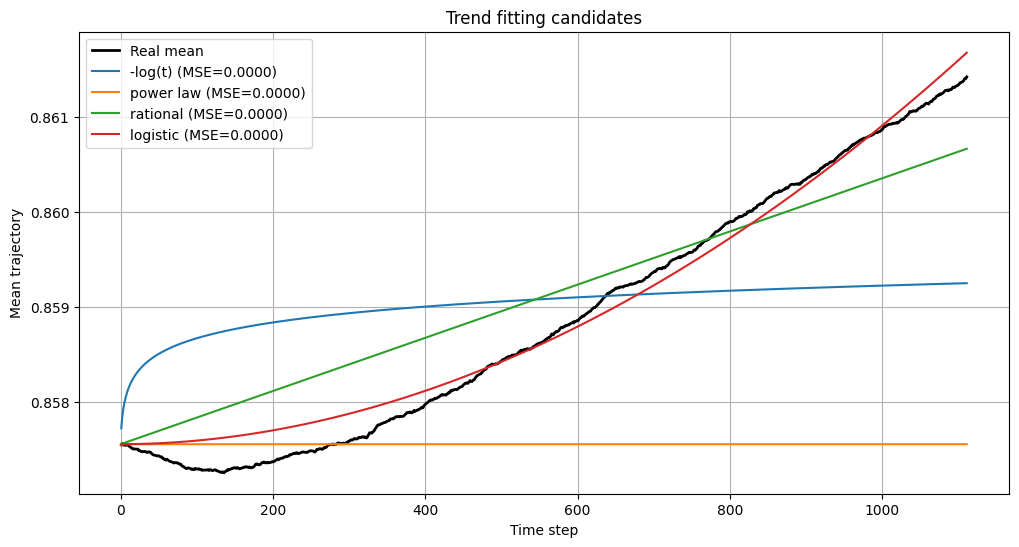

Ранжирование по MSE:
logistic: MSE=0.0000, params=[-5.61815825e-09  1.94713682e+00]
rational: MSE=0.0000, params=[93157334.17339161  5765773.46621259]
-log(t): MSE=0.0000, params=[-0.00024186]
power law: MSE=0.0000, params=[ 6.01615054e-06 -2.07499600e+00]


In [169]:
t, mean_real, results = fit_trend_candidates_fixed(p_trajectories)
plot_trend_candidates(t, mean_real, results)

# Сортировка по MSE
sorted_results = sorted(results.items(), key=lambda x: x[1]["mse"])
print("Ранжирование по MSE:")
for name, res in sorted_results:
    print(f"{name}: MSE={res['mse']:.4f}, params={res['params']}")


## Рациональный тренд лучше всего оценивается 

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def fit_rational_trend(trajectories):
    """
    Фит рационального тренда с фиксированным стартом:
        f(t) = S0 - beta/(t+c) + beta/c
    при t=0 гарантирует f(0) = S0
    """
    num_samples, T = trajectories.shape
    t = np.arange(T)   # теперь от 0 до T-1
    mean_real = trajectories.mean(axis=0)
    S0 = trajectories[0,0]

    def rational_trend(t, beta, c):
        return S0 - beta/(t+c) + beta/c

    popt, _ = curve_fit(rational_trend, t, mean_real, p0=[1.0, 1.0], maxfev=20000)
    beta_hat, c_hat = popt
    fitted_trend = rational_trend(t, beta_hat, c_hat)

    return S0, beta_hat, c_hat, fitted_trend


def detrend_trajectories(trajectories, fitted_trend):
    """
    Вычитает тренд из всех траекторий (теперь размеры совпадают).
    """
    return trajectories - fitted_trend



def plot_detrended(detrended, title="Trajectories after rational detrending"):
    plt.figure(figsize=(12,6))
    for s in detrended:
        plt.plot(s, alpha=0.3, color="black")
    plt.axhline(0, color="red", linestyle="--")
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("Deviation from trend")
    plt.grid(True)
    plt.show()


S0=0.858, beta=63260190.264, c=4747575.003


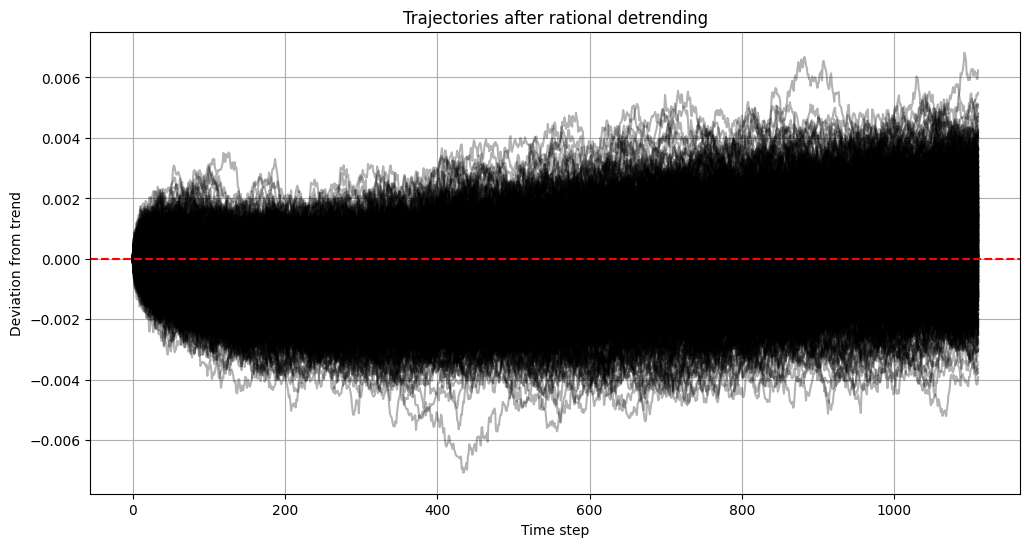

In [171]:
# 1. Фитим рациональный тренд
S0, beta_hat, c_hat, fitted_trend = fit_rational_trend(p_trajectories)
print(f"S0={S0:.3f}, beta={beta_hat:.3f}, c={c_hat:.3f}")

# 2. Убираем тренд
detrended = detrend_trajectories(p_trajectories, fitted_trend)

# 3. Визуализируем
plot_detrended(detrended)


* Дальше будем оценивать именно реальный детеренд -- ычитание срденего, а не оуененный тренд

In [172]:
detrended = p_trajectories - p_trajectories.mean(axis=0)

In [173]:
import numpy as np
import matplotlib.pyplot as plt

def estimate_sigma_wiener(detrended, dt=1.0):
    """
    Оценка sigma для винеровского процесса по приращениям детрендированных траекторий
    """
    increments = detrended[:,1:] - detrended[:,:-1]
    var = np.var(increments, ddof=1)
    sigma_hat = np.sqrt(var / dt)
    return sigma_hat


def simulate_wiener_paths(sigma, n_paths, n_steps, dt=1.0, random_state=None):
    """
    Симуляция винеровских траекторий с дисперсией sigma^2 t
    """
    rng = np.random.default_rng(random_state)
    dW = rng.normal(0, np.sqrt(dt), size=(n_paths, n_steps-1))
    W = np.zeros((n_paths, n_steps))
    W[:,1:] = np.cumsum(sigma * dW, axis=1)
    return W


def plot_real_vs_wiener(detrended, sigma_hat, simulated):
    """
    Два subplot-а: слева реальные траектории, справа — смоделированные винеровские
    """
    fig, axs = plt.subplots(1, 2, figsize=(14,6))

    # реальные
    for s in detrended:
        axs[0].plot(s, alpha=0.3, color="black")
    axs[0].set_title(f"Real detrended trajectories\nEstimated σ={sigma_hat:.3f}")
    axs[0].set_xlabel("Time step")
    axs[0].set_ylabel("Deviation from trend")
    axs[0].grid(True)

    # смоделированные
    for s in simulated:
        axs[1].plot(s, alpha=0.3, color="red")
    axs[1].set_title(f"Simulated Wiener trajectories\nσ={sigma_hat:.3f}")
    axs[1].set_xlabel("Time step")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


Estimated sigma = 0.00017325378


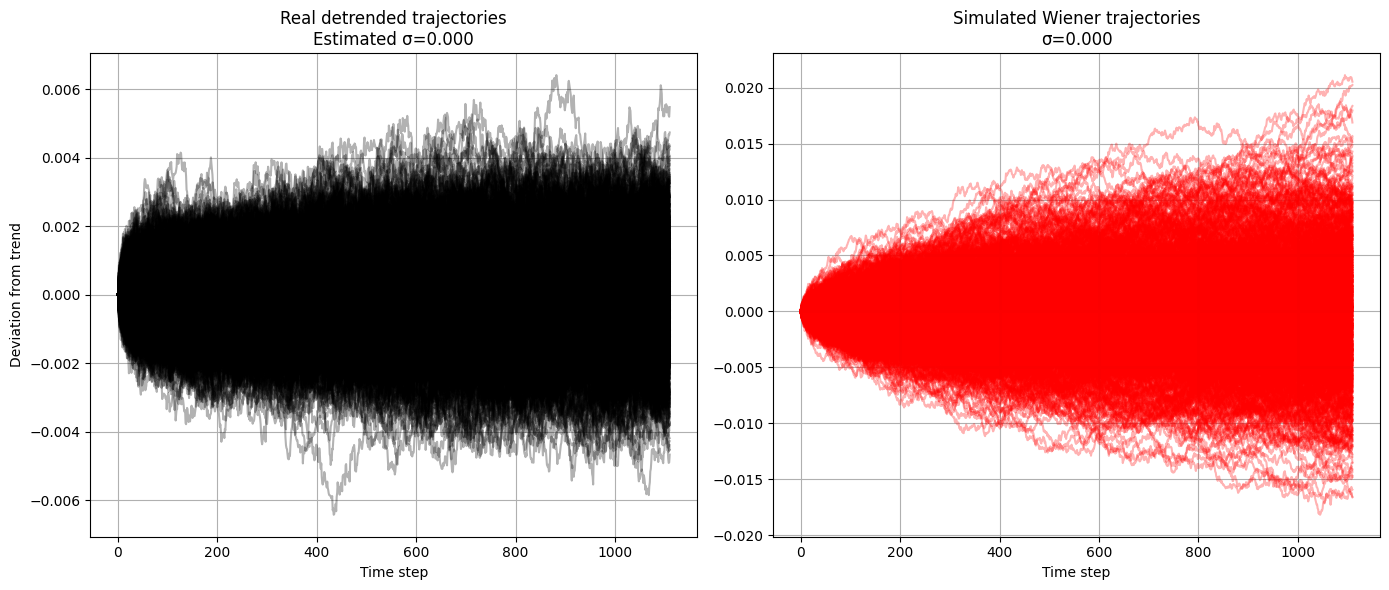

In [174]:
# 1. Оценка sigma
sigma_hat = estimate_sigma_wiener(detrended, dt=1.0)
print("Estimated sigma =", sigma_hat)

# 2. Симуляция винеровских траекторий
n_paths, n_steps = detrended.shape
simulated = simulate_wiener_paths(sigma_hat, n_paths, n_steps, dt=1.0, random_state=42)

# 3. Визуализация
plot_real_vs_wiener(detrended, sigma_hat, simulated)


In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_increments_histogram(detrended, bins=50):
    """
    Строит гистограмму приращений по всем траекториям и накладывает нормальное распределение.
    """
    # приращения
    increments = detrended[:,1:] - detrended[:,:-1]
    increments = increments.flatten()

    # оценки среднего и sigma
    mu_hat = np.mean(increments)
    sigma_hat = np.std(increments, ddof=1)

    # гистограмма
    plt.figure(figsize=(10,6))
    plt.hist(increments, bins=bins, density=True, alpha=0.6, color="black", label="Empirical increments")

    # нормальная аппроксимация
    x = np.linspace(increments.min(), increments.max(), 500)
    pdf = norm.pdf(x, mu_hat, sigma_hat)
    plt.plot(x, pdf, "r-", linewidth=2, label=f"Normal fit (μ={mu_hat:.3e}, σ={sigma_hat:.3e})")

    plt.title("Histogram of increments (detrended trajectories)")
    plt.xlabel("Increment value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    return mu_hat, sigma_hat


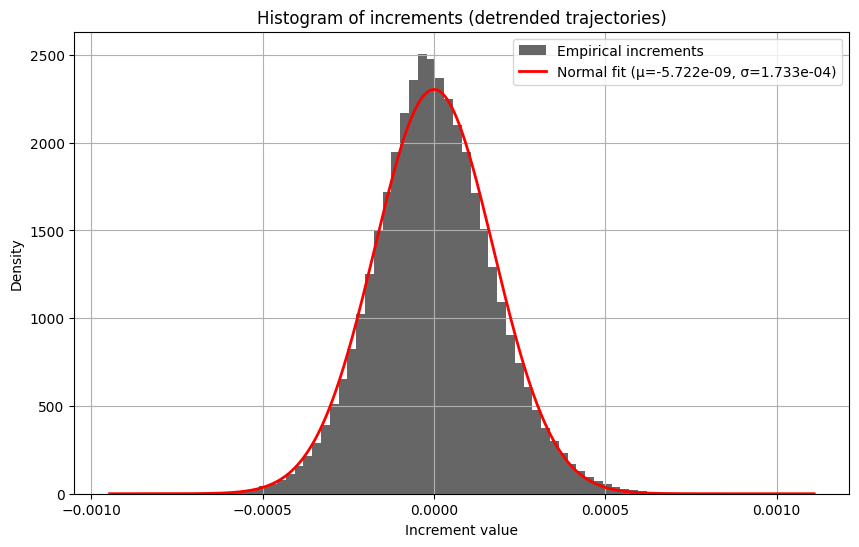

Estimated increments: mean=-5.7220e-09, sigma=1.7325e-04


In [176]:
mu_hat, sigma_hat = plot_increments_histogram(detrended, bins=80)
print(f"Estimated increments: mean={mu_hat:.4e}, sigma={sigma_hat:.4e}")


* приращения походи на нормлаьные, но винеровским плозо оцениваются 

* вероятно они имеют разные сигмы по времени 

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_increments_histogram_overlay(detrended, bins=50):
    """
    Рисует на одном графике гистограммы приращений:
    - в начале
    - в середине
    - в конце
    с наложенными нормальными кривыми.
    """
    n_paths, T = detrended.shape
    thirds = [0, T//3, 2*T//3, T]
    colors = ["blue", "green", "red"]
    labels = ["Start", "Middle", "End"]

    plt.figure(figsize=(10,6))

    for i in range(3):
        # приращения для сегмента
        increments = detrended[:, thirds[i]+1:thirds[i+1]] - detrended[:, thirds[i]:thirds[i+1]-1]
        increments = increments.flatten()

        # оценка нормальных параметров
        mu_hat = np.mean(increments)
        sigma_hat = np.std(increments, ddof=1)

        # гистограмма (прозрачная)
        plt.hist(increments, bins=bins, density=True, alpha=0.3, color=colors[i], label=f"{labels[i]} data")

        # нормальная аппроксимация
        x = np.linspace(increments.min(), increments.max(), 500)
        pdf = norm.pdf(x, mu_hat, sigma_hat)
        plt.plot(x, pdf, color=colors[i], linewidth=2, label=f"{labels[i]} N({mu_hat:.2e}, {sigma_hat:.2e})")

    plt.title("Increment distributions: start vs middle vs end")
    plt.xlabel("Increment value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


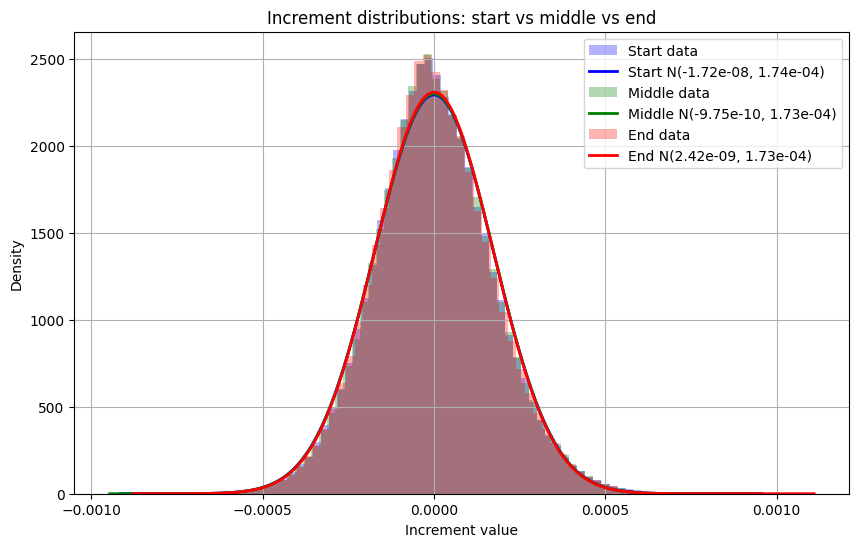

In [178]:
plot_increments_histogram_overlay(detrended, bins=80)


* хм оказалось волатильность не меняется по времени 
* Вероятно приращения скореллированные 

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def estimate_hurst_and_sigma(detrended):
    """
    Оценка H и sigma через дисперсию во времени.
    """
    n_paths, T = detrended.shape
    t = np.arange(1, T+1)
    var_t = detrended.var(axis=0)

    def var_model(t, sigma, H):
        return (sigma**2) * (t**(2*H))

    popt, _ = curve_fit(var_model, t, var_t, p0=[1.0, 0.5], bounds=(0, np.inf))
    sigma_hat, H_hat = popt
    return sigma_hat, H_hat, t, var_t, var_model(t, *popt)


def simulate_fbm(H, sigma, n_paths, n_steps, dt=1.0, random_state=None):
    """
    Симуляция fBM с масштабом sigma.
    """
    rng = np.random.default_rng(random_state)
    t = np.arange(n_steps) * dt

    def cov(i, j):
        return 0.5 * ( (abs(i*dt))**(2*H) + (abs(j*dt))**(2*H) - (abs(i-j)*dt)**(2*H) )

    C = np.fromfunction(np.vectorize(cov), (n_steps, n_steps), dtype=int)
    L = np.linalg.cholesky(C + 1e-12*np.eye(n_steps))

    sims = []
    for _ in range(n_paths):
        z = rng.normal(0, 1, size=n_steps)  # стандартный нормальный
        sims.append(sigma * (L @ z))        # масштабируем на sigma
    return np.array(sims)


Estimated H=0.001, sigma=0.001


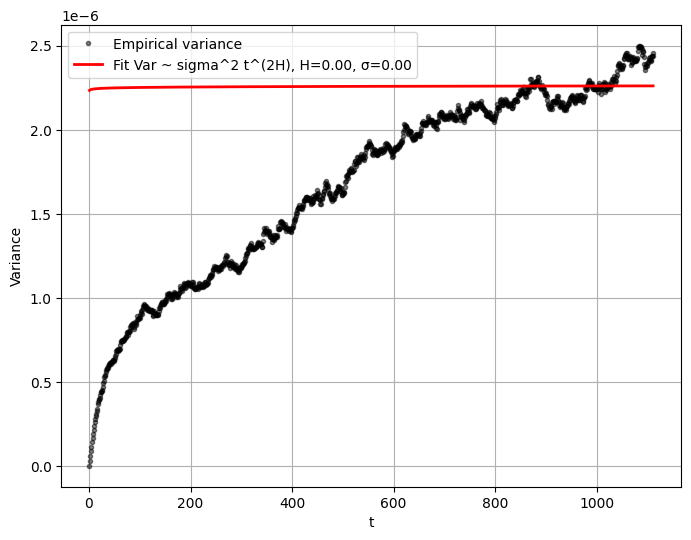

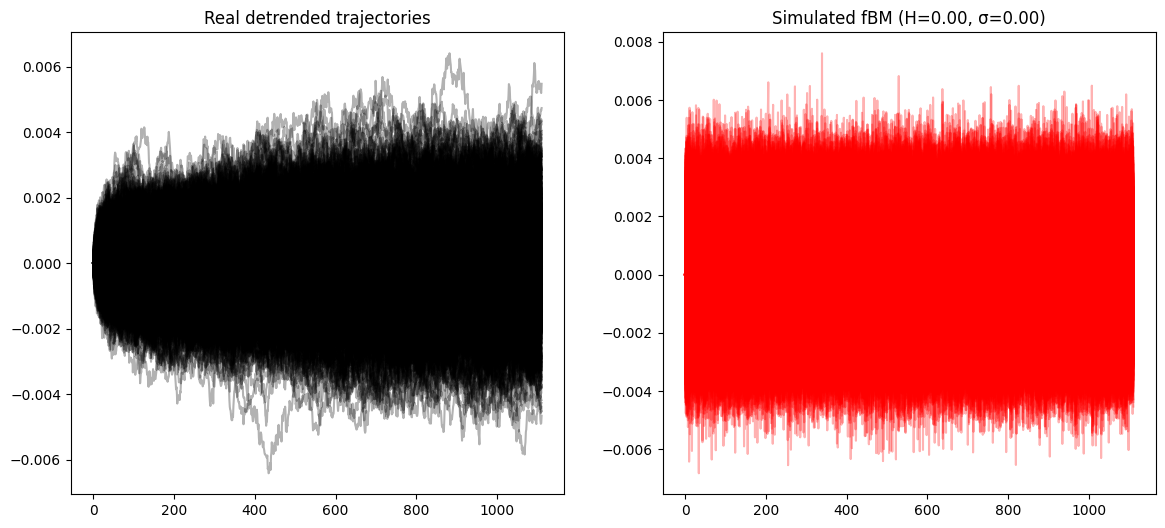

In [180]:
# 1. Фит H и sigma
sigma_hat, H_hat, t, var_emp, var_fit = estimate_hurst_and_sigma(detrended)
print(f"Estimated H={H_hat:.3f}, sigma={sigma_hat:.3f}")

# 2. Симуляция fBM
n_paths, n_steps = detrended.shape
sim_fbm = simulate_fbm(H_hat, sigma_hat, n_paths=1000, n_steps=n_steps, random_state=42)

# 3. Сравнение дисперсий
plt.figure(figsize=(8,6))
plt.plot(t, var_emp, "k.", alpha=0.5, label="Empirical variance")
plt.plot(t, var_fit, "r-", linewidth=2, label=f"Fit Var ~ sigma^2 t^(2H), H={H_hat:.2f}, σ={sigma_hat:.2f}")
plt.xlabel("t")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.show()

# 4. Сравнение траекторий
fig, axs = plt.subplots(1,2, figsize=(14,6))
for s in detrended:
    axs[0].plot(s, alpha=0.3, color="black")
axs[0].set_title("Real detrended trajectories")

for s in sim_fbm:
    axs[1].plot(s, alpha=0.3, color="red")
axs[1].set_title(f"Simulated fBM (H={H_hat:.2f}, σ={sigma_hat:.2f})")

plt.show()


* доабвим калибровку

Raw estimates: H=0.001, sigma=0.001
Calibrated sigma=0.002


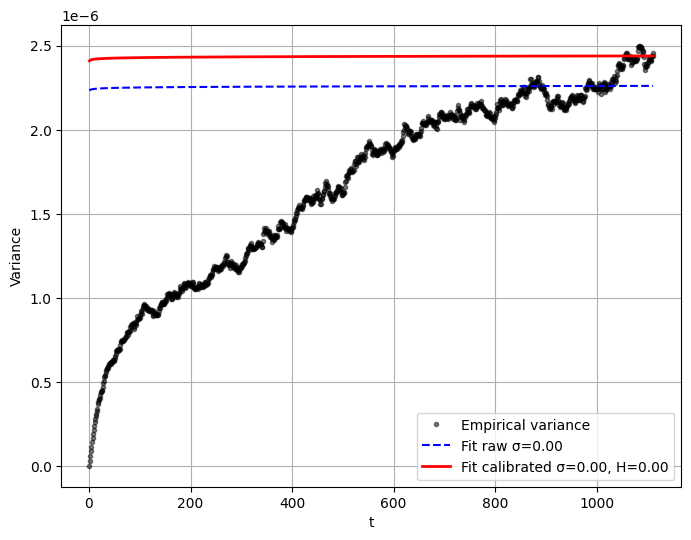

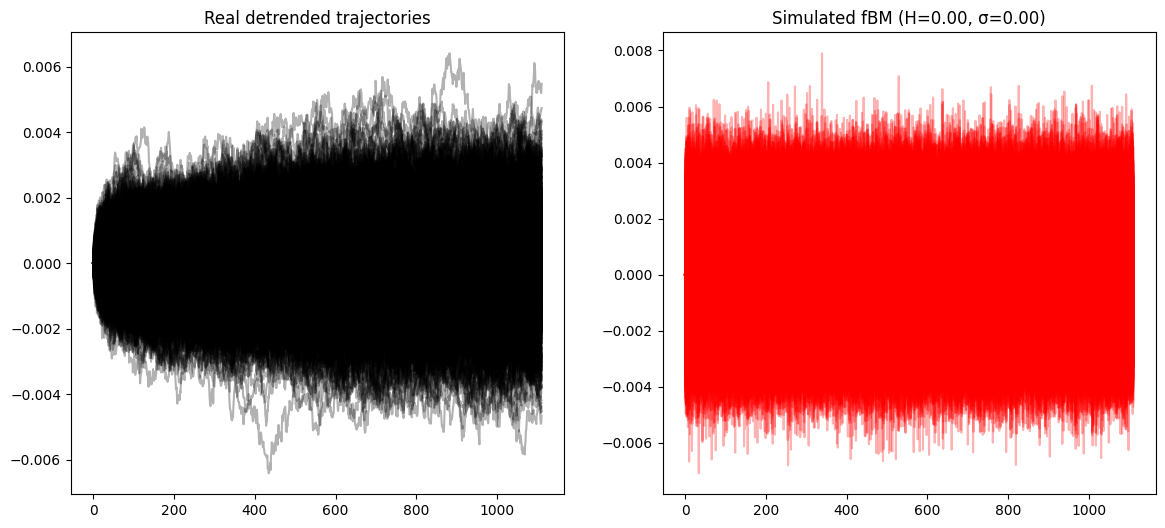

In [181]:


def estimate_hurst_and_sigma(detrended):
    """
    Оценка H и sigma через дисперсию во времени.
    """
    n_paths, T = detrended.shape
    t = np.arange(1, T+1)
    var_t = detrended.var(axis=0)

    def var_model(t, sigma, H):
        return (sigma**2) * (t**(2*H))

    popt, _ = curve_fit(var_model, t, var_t, p0=[1.0, 0.5], bounds=(0, np.inf))
    sigma_hat, H_hat = popt
    return sigma_hat, H_hat, t, var_t, var_model(t, *popt)


def calibrate_sigma(var_emp, H_hat):
    """
    Калибровка sigma по эмпирической дисперсии в последней точке.
    """
    T = len(var_emp)
    sigma_calib = np.sqrt(var_emp[-1] / (T**(2*H_hat)))
    return sigma_calib


def simulate_fbm(H, sigma, n_paths, n_steps, dt=1.0, random_state=None):
    """
    Симуляция fBM с масштабом sigma.
    """
    rng = np.random.default_rng(random_state)
    t = np.arange(n_steps) * dt

    def cov(i, j):
        return 0.5 * ( (abs(i*dt))**(2*H) + (abs(j*dt))**(2*H) - (abs(i-j)*dt)**(2*H) )

    C = np.fromfunction(np.vectorize(cov), (n_steps, n_steps), dtype=int)
    L = np.linalg.cholesky(C + 1e-12*np.eye(n_steps))

    sims = []
    for _ in range(n_paths):
        z = rng.normal(0, 1, size=n_steps)  # стандартный нормальный
        sims.append(sigma * (L @ z))        # масштабируем на sigma
    return np.array(sims)


# 1. Фит H и sigma (метод моментов)
sigma_hat, H_hat, t, var_emp, var_fit = estimate_hurst_and_sigma(detrended)
print(f"Raw estimates: H={H_hat:.3f}, sigma={sigma_hat:.3f}")

# 2. Калибровка sigma по последней точке
sigma_calib = calibrate_sigma(var_emp, H_hat)
print(f"Calibrated sigma={sigma_calib:.3f}")

# 3. Симуляция fBM с калиброванным sigma
n_paths, n_steps = detrended.shape
sim_fbm = simulate_fbm(H_hat, sigma_calib, n_paths=1000, n_steps=n_steps, random_state=42)

# 4. Сравнение дисперсий
var_fit_calib = (sigma_calib**2) * (t**(2*H_hat))

plt.figure(figsize=(8,6))
plt.plot(t, var_emp, "k.", alpha=0.5, label="Empirical variance")
plt.plot(t, var_fit, "b--", linewidth=1.5, label=f"Fit raw σ={sigma_hat:.2f}")
plt.plot(t, var_fit_calib, "r-", linewidth=2, label=f"Fit calibrated σ={sigma_calib:.2f}, H={H_hat:.2f}")
plt.xlabel("t")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.show()

# 5. Сравнение траекторий
fig, axs = plt.subplots(1,2, figsize=(14,6))
for s in detrended:
    axs[0].plot(s, alpha=0.3, color="black")
axs[0].set_title("Real detrended trajectories")

for s in sim_fbm:
    axs[1].plot(s, alpha=0.3, color="red")
axs[1].set_title(f"Simulated fBM (H={H_hat:.2f}, σ={sigma_calib:.2f})")

plt.show()


In [186]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def estimate_hurst_and_sigma(detrended):
    n_paths, T = detrended.shape
    t = np.arange(1, T+1)
    var_t = detrended.var(axis=0)

    # убираем нули, чтобы не было -inf
    mask = var_t > 0
    log_t = np.log(t[mask])
    log_var = np.log(var_t[mask])

    # линейная регрессия log(var) ~ a + b*log(t)
    coeffs = np.polyfit(log_t, log_var, deg=1)
    b, a = coeffs  # y = a + b*x

    H_hat = b / 2
    sigma_hat = np.exp(a / 2)

    # восстановим модель
    var_fit = (sigma_hat**2) * (t**(2*H_hat))

    return sigma_hat, H_hat, t, var_t, var_fit




def calibrate_sigma(var_emp, H_hat):
    """
    Калибровка sigma по эмпирической дисперсии в последней точке.
    """
    T = len(var_emp)
    sigma_calib = np.sqrt(var_emp[-1] / (T**(2*H_hat)))
    return sigma_calib


def simulate_fbm(H, sigma, n_paths, n_steps, dt=1.0, random_state=None):
    """
    Симуляция fBM с масштабом sigma.
    """
    rng = np.random.default_rng(random_state)
    t = np.arange(n_steps) * dt

    def cov(i, j):
        return 0.5 * ( (abs(i*dt))**(2*H) + (abs(j*dt))**(2*H) - (abs(i-j)*dt)**(2*H) )

    C = np.fromfunction(np.vectorize(cov), (n_steps, n_steps), dtype=int)
    L = np.linalg.cholesky(C + 1e-12*np.eye(n_steps))

    sims = []
    for _ in range(n_paths):
        z = rng.normal(0, 1, size=n_steps)
        sims.append(sigma * (L @ z))
    return np.array(sims)


def fbm_visualize(detrended, n_sim=500, random_state=42):
    # --- шаг 1: оценка H и sigma ---
    sigma_hat, H_hat, t, var_emp, var_fit = estimate_hurst_and_sigma(detrended)
    print(f"Raw estimates: H={H_hat:.3f}, sigma={sigma_hat:.3f}")

    # --- шаг 2: калибровка sigma ---
    sigma_calib = calibrate_sigma(var_emp, H_hat)
    print(f"Calibrated sigma={sigma_calib:.3f}")

    # --- шаг 3: симуляция ---
    n_paths, n_steps = detrended.shape
    sim_fbm = simulate_fbm(H_hat, sigma_calib, n_paths=n_sim, n_steps=n_steps, random_state=random_state)

    # --- шаг 4: variance plot ---
    var_fit_calib = (sigma_calib**2) * (t**(2*H_hat))
    plt.figure(figsize=(8,6))
    plt.plot(t, var_emp, "k.", alpha=0.5, label="Empirical variance")
    plt.plot(t, var_fit, "b--", linewidth=1.5, label=f"Raw fit σ={sigma_hat:.2f}")
    plt.plot(t, var_fit_calib, "r-", linewidth=2, label=f"Calibrated σ={sigma_calib:.2f}, H={H_hat:.2f}")
    plt.xlabel("t")
    plt.ylabel("Variance")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- шаг 5: отношение дисперсий ---
    ratio_raw = var_emp / var_fit
    ratio_calib = var_emp / var_fit_calib
    plt.figure(figsize=(8,5))
    plt.plot(t, ratio_raw, "b--", alpha=0.7, label="Empirical / Raw fit")
    plt.plot(t, ratio_calib, "r-", alpha=0.7, label="Empirical / Calibrated fit")
    plt.axhline(1, color="black", linestyle=":")
    plt.xlabel("t")
    plt.ylabel("Ratio")
    plt.legend()
    plt.grid(True)
    plt.title("Variance ratio (should be ~1)")
    plt.show()

    # --- шаг 6: финальные распределения ---
    plt.figure(figsize=(8,5))
    plt.hist(detrended[:,-1], bins=50, alpha=0.5, density=True, label="Empirical final")
    plt.hist(sim_fbm[:,-1], bins=50, alpha=0.5, density=True, label="Simulated final (calibrated)")
    plt.xlabel("X_T")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Final distribution: real vs simulated")
    plt.grid(True)
    plt.show()

    # --- шаг 7: траектории ---
    fig, axs = plt.subplots(1,2, figsize=(14,6))
    for s in detrended[:200]:
        axs[0].plot(s, alpha=0.3, color="black")
    axs[0].set_title("Real detrended trajectories")

    for s in sim_fbm[:200]:
        axs[1].plot(s, alpha=0.3, color="red")
    axs[1].set_title(f"Simulated fBM (H={H_hat:.2f}, σ={sigma_calib:.2f})")

    plt.show()


Raw estimates: H=0.237, sigma=0.000
Calibrated sigma=0.000


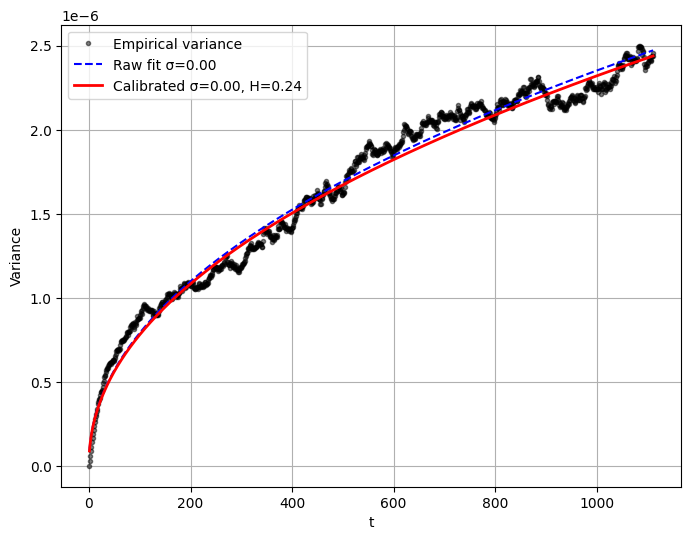

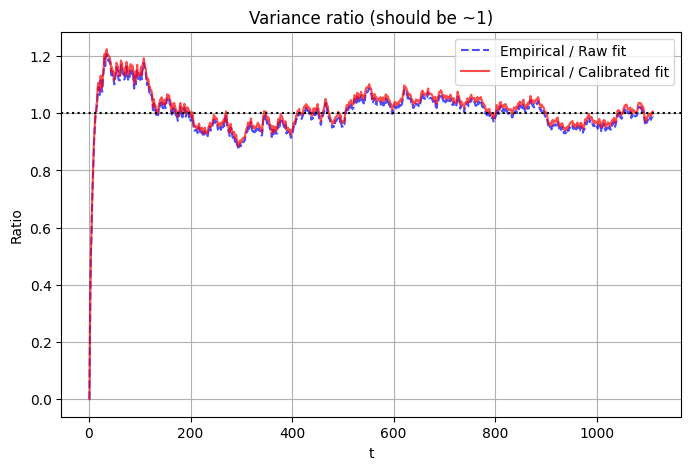

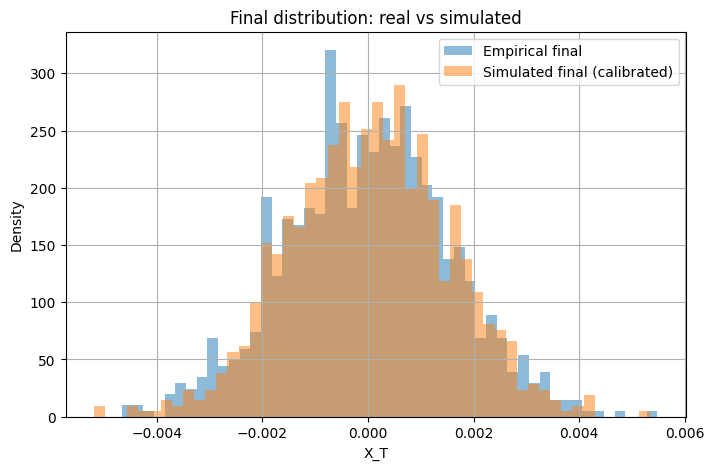

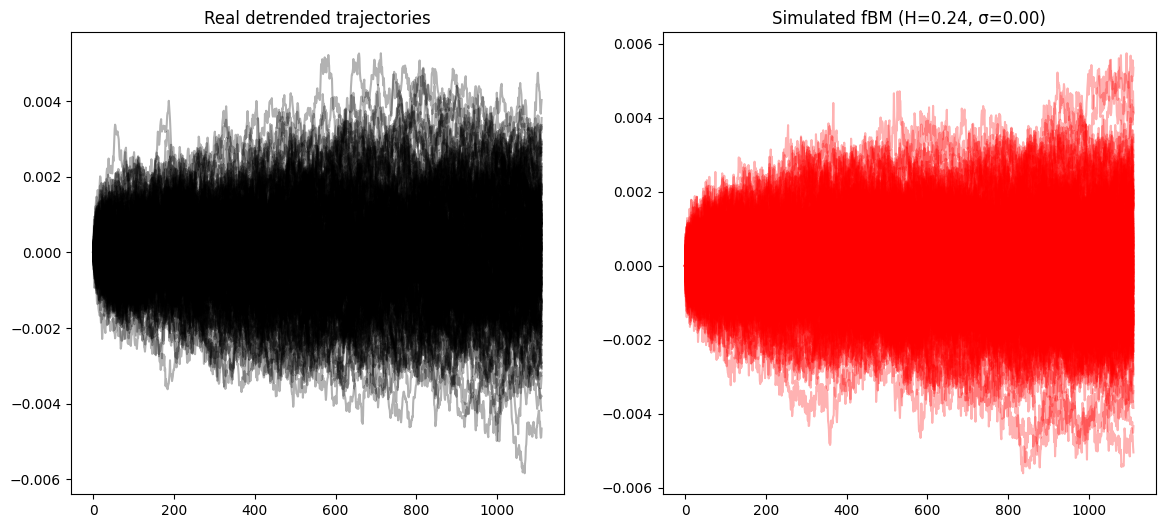

In [187]:
fbm_visualize(detrended, n_sim=1000)
